# Spatial relationships and operations
**based on scipy2018-geospatial**

## goals of the tutorial
- load tabular data files (eg. csv or xls) as geodataframe
- spatial projection conversion
- spatial relationships 
- spatial joins
- spatial operations

**based on the open data of:**
- [ISTAT](https://www.istat.it/it/archivio/222527) Italian National Institute of Statistic 
- [Italian Ministry of Agricultural, Food and Forestry Policies](https://www.politicheagricole.it/)


### requirements
- python knowledge
- pandas
- previous lesson

### status 
*"Spatial is Special"*

---

# SETUP
for the spatial operations we need to improve geopandas with some libraries.

You can use rtree o pygeos 

## rtree
if you want use [rtree](https://rtree.readthedocs.io/en/latest/) you need also to install a C library in your O.S.

Pyton RTree is a wrapper to the library [libspatialiteindex](https://libspatialindex.org/en/latest/)

if you are using a Linux distribution based on Debian (like the instance of Google Colab) you have to install the libspatialindex library before


In [7]:
import platform

try:
  import rtree
except ModuleNotFoundError as e:
  if (platform.system() == 'Linux'):
    !apt-get install libspatialindex-dev
    !pip install rtree==0.9.7
    import rtree

if rtree.__version__ != "0.9.7":
  !pip install -U rtree==0.9.7
  import rtree

## pygeos

[PyGEOS](https://pygeos.readthedocs.io/en/stable/) is a Python library for working with GEOS geometries. It is a wrapper for the GEOS C API.

In [8]:
try:
  import pygeos
except ModuleNotFoundError as e:
  !pip install pygeos==0.10.2
  import pygeos

## geopandas

version 0.10.1

In [ ]:
try:
  import geopandas as gpd
except ModuleNotFoundError as e:
  !pip install geopandas==0.10.1
  import geopandas as gpd
  if gpd.__version__ != "0.10.1":
    !pip install -U geopandas==0.10.1

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import requests 

# data setup
## administrative units of italy

geopackage with the administrative units of italy

The couse offers the file in a geopackage stored [here](https://github.com/napo/geospatial_course_unitn/raw/master/data/istat/istat_administrative_units_generalized_2021.gpkgg)

In [15]:
url = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/istat/istat_administrative_units_generalized_2021.gpkg'

In [16]:
macroregions = gpd.read_file(url,layer="macroregions")

you can repeat the operation ( = direct download) for each layer but it's better to download the file once and load the layers step by step.

In [17]:
# download the file 
geopackage_istat_file = "istat_administrative_units_generalized_2021.gpkg"
r = requests.get(url, allow_redirects=True)
open(geopackage_istat_file, 'wb').write(r.content)

42049536

In [19]:
regions = gpd.read_file(geopackage_istat_file,layer="regions")

In [20]:
provincies = gpd.read_file(geopackage_istat_file,layer="provincies")

In [21]:
municipalities = gpd.read_file(geopackage_istat_file,layer="municipalities")

In [22]:
macroregions

,COD_RIP,DEN_RIP,geometry
0,1,Nord-Ovest,"MULTIPOLYGON (((568226.691 4874823.573, 568219..."
1,2,Nord-Est,"MULTIPOLYGON (((618343.929 4893985.661, 618335..."
2,3,Centro,"MULTIPOLYGON (((875952.995 4524692.050, 875769..."
3,4,Sud,"MULTIPOLYGON (((1083358.846 4416348.741, 10833..."
4,5,Isole,"MULTIPOLYGON (((822886.611 3935355.889, 822871..."


## monumental trees of Italy
The italian Ministery of Agricultural offers a datasets the location of each monumental tree for each region of Italy.

Visit this [page](https://www.politicheagricole.it/flex/cm/pages/ServeBLOB.php/L/IT/IDPagina/11260)


### from a dataframe to a geodataframe
we have a several XLS files with a sheet where there is a column with latitude and another with longitude


In [23]:
# here we created a list with all the resources for each italian region listed on the website
regional_sources=[]
#abruzzo
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/0%252F8%252F1%252FD.f2005fd478b7477df1d4/P/BLOB%3AID%3D11260/E/xls")
#bolzano
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/8%252F9%252F0%252FD.f29391d6deaa808addeb/P/BLOB%3AID%3D11260/E/xls")
# campania
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/5%252Fd%252F5%252FD.76b727d50600037545c6/P/BLOB%3AID%3D11260/E/xls")
# fvg
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/f%252Fd%252F3%252FD.946890f9eaea54ae5ea1/P/BLOB%3AID%3D11260/E/xls")
# liguria
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/e%252F3%252F7%252FD.05dfc2cec6e9136d75a8/P/BLOB%3AID%3D11260/E/xls")
# marche
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/b%252Fc%252F9%252FD.f141f45553f7a7a66b32/P/BLOB%3AID%3D11260/E/xls")
# piemonte
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/a%252Fa%252Fa%252FD.0948793850e0ffb9b8f8/P/BLOB%3AID%3D11260/E/xls")
# sardegna
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/b%252Fb%252F4%252FD.461f367f4970e94e4ace/P/BLOB%3AID%3D11260/E/xls")
# toscana
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/b%252Fd%252Fb%252FD.769c1bc18ed0fd6c7525/P/BLOB%3AID%3D11260/E/xls")
# umbria
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/1%252F4%252F6%252FD.9c2d18fc20e20bddf41c/P/BLOB%3AID%3D11260/E/xls")
# veneto
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/2%252F1%252F5%252FD.c0a841fd03577da4f4df/P/BLOB%3AID%3D11260/E/xls")
# basilicata
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/0%252F4%252Fb%252FD.593ccd772b2035897865/P/BLOB%3AID%3D11260/E/xls")
# calabria
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/8%252F5%252F9%252FD.791fdf3bf4b0e58ba67e/P/BLOB%3AID%3D11260/E/xls")
# emilia romagna
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/8%252F3%252Ff%252FD.f2adadc654c2f900a2e8/P/BLOB%3AID%3D11260/E/xls")
# lazio
regional_sources.append('https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/b%252F2%252F2%252FD.6934fcd6bbd065d1c9e3/P/BLOB%3AID%3D11260/E/xls')
# lombardia
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/2%252F3%252F5%252FD.729e47446f1af140a478/P/BLOB%3AID%3D11260/E/xls")
# molise
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/f%252Fd%252F3%252FD.c331aee0b88fde31643f/P/BLOB%3AID%3D11260/E/xls")
# puglia
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/0%252Fc%252F7%252FD.f030e1f218aaa3986719/P/BLOB%3AID%3D11260/E/xls")
# sicilia
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/b%252Fd%252F6%252FD.c0ba2f7d6431aeea8012/P/BLOB%3AID%3D11260/E/xls")
#trento
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/8%252F5%252Fe%252FD.3b60c3340ad1de02b36e/P/BLOB%3AID%3D11260/E/xls")
# val d'aosta
regional_sources.append("https://www.politicheagricole.it/flex/cm/pages/ServeAttachment.php/L/IT/D/b%252F9%252F2%252FD.03014417b256a41ab612/P/BLOB%3AID%3D11260/E/xls")

It's also possibile scrape the URL of the XLS file with this code (contribution by Aurora Maria Tumminello)

In [24]:
try:
  import bs4 
except ModuleNotFoundError as e:
  !pip install bs4
  import bs4 
if bs4.__version__ != "4.9.3":
  !pip install -U bs4==4.9.3
  import bs4

In [27]:
# Saving URLs to download Regional data about Monumental Trees
# Get HTML content
html = requests.get("https://www.politicheagricole.it/flex/cm/pages/ServeBLOB.php/L/IT/IDPagina/11260#id-bed7384af14fdba2da436d64155c62b1").content
# Parse the document with BeautifulSoup
soup = bs4.BeautifulSoup(html, 'html.parser')
# Find all elements of the selected class (the ones we're going to download)
regions_urls = soup.findAll("div", {"class": "blob-element-download BLOBAlignLeft"})

# Saving downloading links inside the list
regional_sources=[]
for e in regions_urls:
  regional_sources.append(e.a['href'])

you can donwload each dataset directly with pandas with an instruction like this:
```python
df = pd.read_excel(regional_sources[0])
```
... but you can obtain some mistakes due a SSL error
 
you can solve in this way with the following code following this [thread on stackoverflow](https://stackoverflow.com/questions/38015537/python-requests-exceptions-sslerror-dh-key-too-small)

In [26]:
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'
try:
    requests.packages.urllib3.contrib.pyopenssl.DEFAULT_SSL_CIPHER_LIST += 'HIGH:!DH:!aNULL'
except AttributeError:
    # no pyopenssl support used / needed / available
    pass

monumental_trees = None
for source in regional_sources:
    req= requests.get(source)
    if (monumental_trees is None):
        monumental_trees = pd.read_excel(req.content)
        firststep = False
    else:
        monumental_trees = monumental_trees.append(pd.read_excel(req.content))

### investigate the data

In [28]:
monumental_trees.shape[0]

3665

In [29]:
monumental_trees

,PROGR,REGIONE,ID SCHEDA,PROVINCIA,COMUNE,LOCALITÀ,LATITUDINE SU GIS,LONGITUDINE SU GIS,ALTITUDINE (m s.l.m.),CONTESTO URBANO,SPECIE NOME SCIENTIFICO,SPECIE NOME VOLGARE,CIRCONFERENZA FUSTO (cm),ALTEZZA (m),CRITERI DI MONUMENTALITÀ,PROPOSTA DICHIARAZIONE NOTEVOLE INTERESSE PUBBLICO,Unnamed: 16,RIFERIMENTO LEGISLATIVO
0,1,ABRUZZO,01/A235/CH/13,Chieti,Altino,Le Macchie Articciaro,"42° 05' 14,02''","14° 20' 34,97''",215.0,no,Juniperus oxycedrus L.,Ginepro coccolone,125,7,a) età e/o dimensioni\nb) forma e portamento\n...,no,NaN,NaN
1,2,ABRUZZO,01/A367/CH/13,Chieti,Archi,Serra Castello,"42° 04' 43,15''","14° 22' 57,14''",525.0,no,Arbutus unedo L.,Corbezzolo,125,5.5,a) età e/o dimensioni\nd) rarità botanica,no,NaN,NaN
2,3,ABRUZZO,01/A485/CH/13,Chieti,Atessa,Santa Lucia - Piana Sant'Antonio,"42° 06' 41,82''","14° 25' 55,52''",125.0,sì,Quercus pubescens Willd.,Roverella,355,17,a) età e/o dimensioni,no,NaN,NaN
3,4,ABRUZZO,01/A956/CH/13,Chieti,Bomba,Cementificio - Casale Nasuti,"42° 03' 07,95''","14° 21' 48,11''",400.0,no,Quercus pubescens Willd.,Roverella,530,22,a) età e/o dimensioni\nc) valore ecologico,no,NaN,NaN
4,5,ABRUZZO,02/A956/CH/13,Chieti,Bomba,Cementificio - Casale Nasuti,"42° 03' 07,11''","14° 21' 48,97''",400.0,no,Quercus pubescens Willd.,Roverella,475,21,a) età e/o dimensioni,no,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,106,VALLE D'AOSTA,03/L647/AO/02,Aosta,Valsavarenche,Bosco di Protezione di Bien (Particella Econo...,"45° 34' 25,9''","7° 12' 51,4''",1721.0,no,Larix decidua Mill.,Larice,372,31.0,a) età e/o dimensioni\nb) forma e portamento,no,NaN,NaN
106,107,VALLE D'AOSTA,04/L647/AO/02,Aosta,Valsavarenche,Bosco di Protezione di Bien (Particella Econo...,"45° 34' 34,2''","7° 12' 50,4''",1712.0,no,Larix decidua Mill.,Larice,368,25.0,a) età e/o dimensioni\nb) forma e portamento,no,NaN,NaN
107,108,VALLE D'AOSTA,05/L647/AO/02,Aosta,Valsavarenche,Bosco di Protezione di Bien (Particella Econo...,"45° 34' 24,3''","7° 12' 52,8''",1718.0,no,Larix decidua Mill.,Larice,348,28.0,a) età e/o dimensioni\nb) forma e portamento,no,NaN,NaN
108,109,VALLE D'AOSTA,06/L647/AO/02,Aosta,Valsavarenche,Bosco di Protezione di Bien (Particella Econo...,"45° 34' 23,6''","7° 12' 54,8''",1771.0,no,Larix decidua Mill.,Larice,358,26.0,a) età e/o dimensioni\nb) forma e portamento,no,NaN,NaN


In [30]:
try:
  import dms2dec 
except ModuleNotFoundError as e:
  !pip install dms2dec==0.1
  import dms2dec

latitude and longitude here are stored in degrees.<br/>
Eg.<br/>
45° 34' 23,2''	

you need to transform it in decimal degree: 

```javascript
degree + minutes / 60 + seconds/(60*60) 
```

and assume negative values if the data is in West or South. 

here an example code

In [31]:
import re
lat = '''45°34'23.2"N'''
deg, minutes, seconds, direction =  re.split('[°\'"]', lat)
(float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

45.57311111111112

a good blog post to explain the problem is here 

![](https://i0.wp.com/cdnssl.ubergizmo.com/wp-content/uploads/2016/02/lines-of-latitude-and-longitude.png)

https://www.ubergizmo.com/how-to/read-gps-coordinates/



In [32]:
# dms2dec is an useful library for this conversion
from dms2dec.dms_convert import dms2dec

In [33]:
# change commas in dots
monumental_trees['LATITUDINE SU GIS'] = monumental_trees['LATITUDINE SU GIS'].apply(lambda x: x.replace(",", "."))
monumental_trees['LONGITUDINE SU GIS'] = monumental_trees['LONGITUDINE SU GIS'].apply(lambda x: x.replace(",", "."))

In [34]:
# create the columns with the information in decimal degree
monumental_trees['latitude'] = monumental_trees['LATITUDINE SU GIS'].apply(lambda x: dms2dec(x))
monumental_trees['longitude'] = monumental_trees['LONGITUDINE SU GIS'].apply(lambda x: dms2dec(x))

In [35]:
monumental_trees.columns

Index(['PROGR', 'REGIONE', 'ID SCHEDA', 'PROVINCIA', 'COMUNE', 'LOCALITÀ',
       'LATITUDINE SU GIS', 'LONGITUDINE SU GIS', 'ALTITUDINE (m s.l.m.)',
       'CONTESTO URBANO', 'SPECIE NOME SCIENTIFICO', 'SPECIE NOME VOLGARE',
       'CIRCONFERENZA FUSTO (cm)', 'ALTEZZA (m)', 'CRITERI DI MONUMENTALITÀ',
       'PROPOSTA DICHIARAZIONE NOTEVOLE INTERESSE PUBBLICO', 'Unnamed: 16',
       'RIFERIMENTO LEGISLATIVO', 'latitude', 'longitude'],
      dtype='object')

In [36]:
# rename some columns
columns= {
   'REGIONE': 'region',
   'PROVINCIA': 'province',
   'COMUNE': 'municipality',
   'LOCALITÀ': 'place',
   'ALTITUDINE (m s.l.m.)':'altitude',
   'CONTESTO URBANO':'urban_place',
   'SPECIE NOME SCIENTIFICO':'species_scientific_name',
   'SPECIE NOME VOLGARE':'species_common_name'
  }


In [37]:
monumental_trees.rename(columns=columns,inplace=True)

In [38]:
# choose only the columns we need
monumental_trees = monumental_trees[['region','province','municipality','place','altitude','urban_place','species_scientific_name','species_common_name','latitude','longitude']]


In [39]:
monumental_trees.head(5)

,region,province,municipality,place,altitude,urban_place,species_scientific_name,species_common_name,latitude,longitude
0,ABRUZZO,Chieti,Altino,Le Macchie Articciaro,215.0,no,Juniperus oxycedrus L.,Ginepro coccolone,42.087228,14.343047
1,ABRUZZO,Chieti,Archi,Serra Castello,525.0,no,Arbutus unedo L.,Corbezzolo,42.078653,14.382539
2,ABRUZZO,Chieti,Atessa,Santa Lucia - Piana Sant'Antonio,125.0,sì,Quercus pubescens Willd.,Roverella,42.111617,14.432089
3,ABRUZZO,Chieti,Bomba,Cementificio - Casale Nasuti,400.0,no,Quercus pubescens Willd.,Roverella,42.052208,14.363364
4,ABRUZZO,Chieti,Bomba,Cementificio - Casale Nasuti,400.0,no,Quercus pubescens Willd.,Roverella,42.051975,14.363603


### geodataframe creation from the dataframe with x (longitude) and y (latitude) 

GeoDataFrame [constructor](https://geopandas.org/reference/geopandas.GeoDataFrame.html):
* a dataframe (or dictionary)
* the CRS
* a geometry field expressed in WKT (eg. POINT (1,3)) 



now we are ready to create the geodataframe.
the operation are:
- creation of a geometry column based on the WKT syntax
- transform the DataFrame in GeoDataFrame

In [89]:
geo_monumental_trees = gpd.GeoDataFrame(
    monumental_trees,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(monumental_trees.longitude, monumental_trees.latitude))

In [90]:
geo_monumental_trees.to_file("geo_monumental_trees.geojson",driver="GeoJSON")

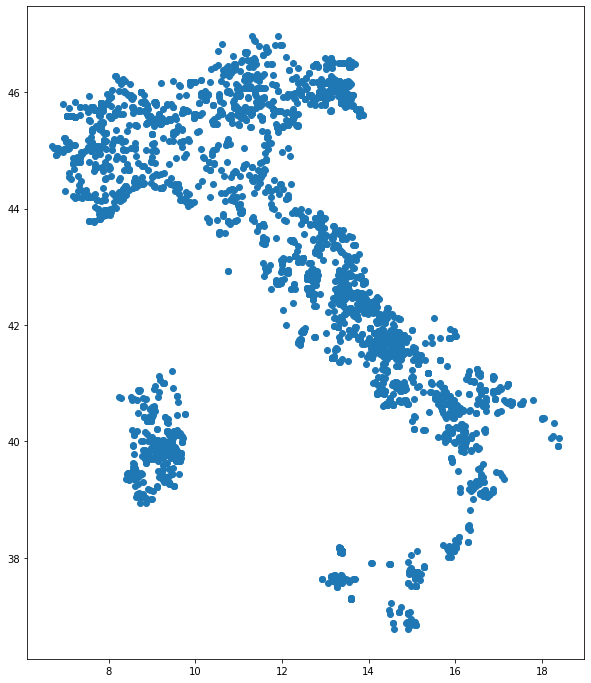

In [41]:
geo_monumental_trees.plot(figsize=(12,12))
plt.show()

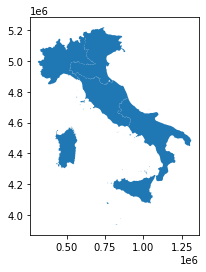

In [42]:
macroregions.plot()
plt.show()

overlay the layers

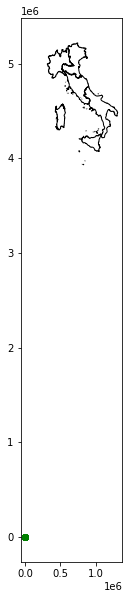

In [43]:
ax = macroregions.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
geo_monumental_trees.plot(ax=ax,color="green")
plt.show()

**ERROR**!<br/>
We need to use the same projection!!!<br/>
The projection used in our geodataframe of ISTAT is EPSG:32632

In [44]:
macroregions.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

overlay the layers by using the same projection

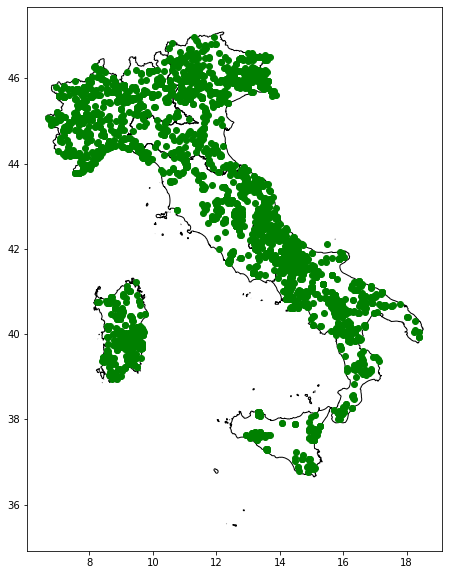

In [45]:
ax = macroregions.to_crs(epsg=4326).plot(edgecolor='k', facecolor='none', figsize=(15, 10))
geo_monumental_trees.plot(ax=ax,color="green")
plt.show()

---
# Spatial relationships 
## how two spatial objects relate to each other 

![](https://upload.wikimedia.org/wikipedia/commons/5/55/TopologicSpatialRelarions2.png)

from [https://en.wikipedia.org/wiki/Spatial_relation](https://en.wikipedia.org/wiki/Spatial_relation)

## Relationships between individual objects

Eg.<br>
Is this library located in the north-east Italian macro-region?

we need the north-east italian macro-region in wgs84

In [46]:
macroregions

,COD_RIP,DEN_RIP,geometry
0,1,Nord-Ovest,"MULTIPOLYGON (((568226.691 4874823.573, 568219..."
1,2,Nord-Est,"MULTIPOLYGON (((618343.929 4893985.661, 618335..."
2,3,Centro,"MULTIPOLYGON (((875952.995 4524692.050, 875769..."
3,4,Sud,"MULTIPOLYGON (((1083358.846 4416348.741, 10833..."
4,5,Isole,"MULTIPOLYGON (((822886.611 3935355.889, 822871..."


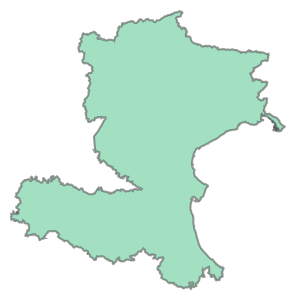

In [47]:
macroregions.geometry[1]

In [48]:
northeast = macroregions.to_crs(epsg=4326).geometry[1]

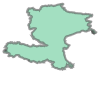

In [49]:
northeast

## let's start with just one point



so we will choose a library in Trento (north east italy)

In [50]:
geo_monumental_trees[geo_monumental_trees.municipality == 'Trento'].head(5)

,region,province,municipality,place,altitude,urban_place,species_scientific_name,species_common_name,latitude,longitude,geometry
65,TRENTO,Trento,Trento,Povo - Ex-Villa Thun - Piazza Manci 15,405.0,sì,Sequoiadendron giganteum (Lindl.) J. Buchholz,Sequoia gigante,46.065997,11.155264,POINT (11.15526 46.06600)
66,TRENTO,Trento,Trento,Maderno - Villa Maria,488.0,sì,Aesculus hippocastanum L.,Ippocastano,46.090008,11.140311,POINT (11.14031 46.09001)
67,TRENTO,Trento,Trento,Povo - Villa Lubich,455.0,sì,Sequoiadendron giganteum (Lindl.) J. Buchholz,Sequoia gigante,46.066589,11.160269,POINT (11.16027 46.06659)
68,TRENTO,Trento,Trento,P. Sso Cimirlo - Casare,790.0,no,Prunus avium L.,Ciliegio selvatico,46.064825,11.186625,POINT (11.18662 46.06482)
69,TRENTO,Trento,Trento,Malga Brigolina,943.0,no,Fagus sylvatica L.,Faggio,46.059850,11.061781,POINT (11.06178 46.05985)


we choose the first line and extrac the geometry

In [51]:
monumental_tree_in_trento = geo_monumental_trees[geo_monumental_trees.municipality == 'Trento'].head(1).geometry.values[0]

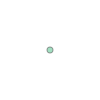

In [52]:
monumental_tree_in_trento

## within relation
in our case:<br>&nbsp;&nbsp;&nbsp;&nbsp;it's the point inside the area?

In [53]:
monumental_tree_in_trento.within(northeast)

True

## contain relation
in our case:<br>&nbsp;&nbsp;&nbsp;&nbsp;does the area contain the point?

In [54]:
northeast.contains(monumental_tree_in_trento)

True

we can iterate the operation for each point

_very slow!_

.. so we work with an only one point

In [55]:
monumental_trees_northeast = geo_monumental_trees[geo_monumental_trees.within(northeast)]
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [56]:
monumental_trees_northeast.shape

(782, 11)

In [57]:
monumental_trees_northeast.region.unique()

array(['BOLZANO', 'FRIULI VENEZIA GIULIA', 'VENETO', 'EMILIA-ROMAGNA',
       'LAZIO', 'TRENTO'], dtype=object)

.. **LAZIO** isn't a region of the North-East Italy

In [58]:
monumental_trees_northeast[monumental_trees_northeast.region == 'LAZIO']

,region,province,municipality,place,altitude,urban_place,species_scientific_name,species_common_name,latitude,longitude,geometry
66,LAZIO,Latina,Priverno,Parco Gallio - San Martino,44.0,no,Quercus frainetto Ten.,Farnetto,45.655747,12.110947,POINT (12.11095 45.65575)


In [59]:
regions[regions.DEN_REG == 'Lazio'].to_crs(epsg=4326).bounds

,minx,miny,maxx,maxy
11,11.44937,40.784734,14.027645,42.838683




---


<div class="alert alert-info" style="font-size:120%">
<b>REFERENCE</b>: <br>

Overview of the different functions to check spatial relationships (*spatial predicate functions*):
<ul>
    <li>`equals`</li>
<li>`contains`</li>
<li>`crosses`</li>
<li>`disjoint`</li>
<li>`intersects`</li>
<li>`overlaps`</li>
<li>`touches`</li>
<li>`within`</li>
<li>`covers`</li>
</ul>


See https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships for an overview of those methods.


See https://en.wikipedia.org/wiki/DE-9IM for all details on the semantics of those operations. 

# Spatial Joins

You can create a join like the usual [join](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) between pandas dataframe by using a spatial relationship with the function [geopandas.sjoin](http://geopandas.readthedocs.io/en/latest/reference/geopandas.sjoin.html)

In [60]:
monumental_trees_and_macroregions = gpd.sjoin(macroregions.to_crs(epsg=4326), 
                          geo_monumental_trees, how='inner', predicate='contains', lsuffix='macroregions_', rsuffix='trees')
%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


In [61]:
monumental_trees_and_macroregions.columns

Index(['COD_RIP', 'DEN_RIP', 'geometry', 'index_trees', 'region', 'province',
       'municipality', 'place', 'altitude', 'urban_place',
       'species_scientific_name', 'species_common_name', 'latitude',
       'longitude'],
      dtype='object')

In [62]:
monumental_trees_and_macroregions.shape

(3660, 14)

In [63]:
monumental_trees_and_macroregions.head(5)

,COD_RIP,DEN_RIP,geometry,index_trees,region,province,municipality,place,altitude,urban_place,species_scientific_name,species_common_name,latitude,longitude
0,1,Nord-Ovest,"MULTIPOLYGON (((9.85132 44.02340, 9.85122 44.0...",61,LIGURIA,La Spezia,Monterosso al Mare,Santuario Madonna di Soviore,495.0,no,Insieme omogeneo di Quercus ilex L.,Leccio,44.160292,9.663494
0,1,Nord-Ovest,"MULTIPOLYGON (((9.85132 44.02340, 9.85122 44.0...",53,LIGURIA,La Spezia,Beverino,Palazzo Costa - Via Castagna Rossa 15,180.0,no,Cedrus libani A.Richard,Cedro del Libano,44.192347,9.780747
0,1,Nord-Ovest,"MULTIPOLYGON (((9.85132 44.02340, 9.85122 44.0...",55,LIGURIA,La Spezia,Carrodano,Mattarana - Via Primo Maggio,473.0,sì,Quercus crenata Lam.,Cerro-Sughera,44.246278,9.615614
0,1,Nord-Ovest,"MULTIPOLYGON (((9.85132 44.02340, 9.85122 44.0...",54,LIGURIA,La Spezia,Calice al Cornoviglio,Monte Ferro,850.0,no,Betula alba L. syn Betula pubescens Ehrh.,Betulla pubescente,44.252711,9.859122
0,1,Nord-Ovest,"MULTIPOLYGON (((9.85132 44.02340, 9.85122 44.0...",64,LIGURIA,La Spezia,Rocchetta di Vara,Molino Rotato - Pirolo,710.0,no,Quercus pubescens Willd.,Roverella,44.282294,9.781239


In [64]:
monumental_trees_and_macroregions.geom_type.unique()

array(['MultiPolygon'], dtype=object)

... and now you can investigate the new geodataframe

In [65]:
monumental_trees_and_macroregions.groupby(['DEN_RIP']).index_trees.count()

DEN_RIP
Centro         536
Isole          568
Nord-Est       782
Nord-Ovest     733
Sud           1041
Name: index_trees, dtype: int64

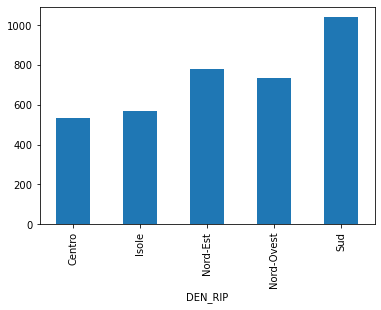

In [66]:
monumental_trees_and_macroregions.groupby(['DEN_RIP']).index_trees.count().plot(kind='bar')
plt.show()


<div class="alert alert-info" style="font-size:120%">
<b>SPATIAL JOIN </b>= *transferring attributes from one layer to another based on their spatial relationship*<br/>

Different parts of this operations:
<ul>
    <li>The GeoDataFrame to which we want add information</li>
    <li>The GeoDataFrame that contains the information we want to add</li>
    <li>The spatial relationship we want to use to match both datasets ('intersects', 'contains', 'within')</li>
    <li>The type of join: left or inner join</li>
</ul>


---
# Spatial operations 
GeoPandas provide analysis methods that return new geometric objects (based on shapely)

See [https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods](https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods) for more details.

## buffer
*object.buffer(distance, resolution=16, cap_style=1, join_style=1, mitre_limit=5.0)*

Returns an approximate representation of all points within a given distance of the this geometric object.

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/buffer.png)


In [67]:
monumental_tree_in_trento_32632 = geo_monumental_trees[geo_monumental_trees.municipality == 'Trento'].to_crs(32632).geometry.values[0]

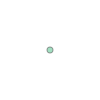

In [68]:
monumental_tree_in_trento_32632

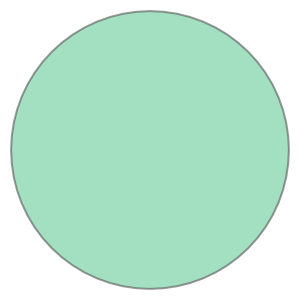

In [69]:
monumental_tree_in_trento_32632.buffer(9000) # a circle with a ray of 9000 meters

due to the algorithm with which the buffer is built, as the value increases, from whatever geometry one starts, the result will take on more and more the shape of a circumference.


<img src="https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/buffer.gif" width="450px"/>

## simplify

*object.simplify(tolerance, preserve_topology=True)*

    Returns a simplified representation of the geometric object.


In [70]:
northeast_geometry = macroregions[macroregions.COD_RIP==2].geometry.values[0]

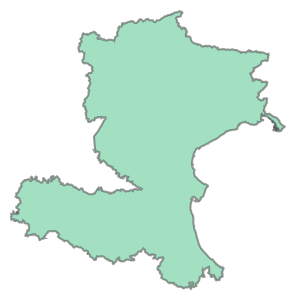

In [71]:
northeast_geometry

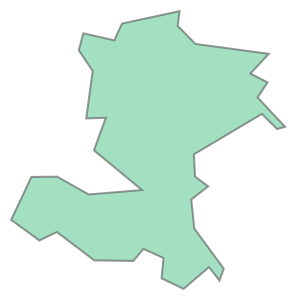

In [72]:
northeast_geometry.simplify(10000,preserve_topology=False)

## Es. symmetric_difference
*object.symmetric_difference(other)*

    Returns a representation of the points in this object not in the other geometric object, and the points in the other not in this geometric object.


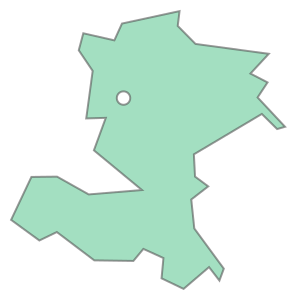

In [73]:
northeast_geometry.simplify(10000,preserve_topology=False).symmetric_difference(monumental_tree_in_trento_32632.buffer(9000))

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER:</b>

GeoPandas (and Shapely for the individual objects) provides a whole lot of basic methods to analyse the geospatial data (distance, length, centroid, boundary, convex_hull, simplify, transform, ....), much more than the few that we can touch in this tutorial.
<ul>
<li>An overview of all methods provided by GeoPandas can be found here: <a href="https://geopandas.readthedocs.io/en/latest/docs/reference.html">https://geopandas.readthedocs.io/en/latest/docs/reference.html</a></li>
    </ul>



---
# Clip 

Extracts input features that overlay the clip features.

![](https://desktop.arcgis.com/en/arcmap/10.3/tools/analysis-toolbox/GUID-6D3322A8-57EA-4D24-9FFE-2A9E7C6B29EC-web.gif)

```python
 geopandas.clip(gdf, mask, keep_geom_type=False)
 ```
 *gdf* = geodataframe<Br/>
 *mask* = polygon 

In [74]:
municipalities_inside_circle = municipalities.clip(monumental_tree_in_trento_32632.buffer(9000))

In [75]:
municipalities_inside_circle.COMUNE.unique()

array(['Caldonazzo', 'Altopiano della Vigolana', 'Calceranica al Lago',
       'Tenna', 'Garniga Terme', 'Vignola-Falesina', 'Pergine Valsugana',
       'Trento', 'Civezzano', 'Vallelaghi', 'Fornace', 'Baselga di Pinè',
       'Albiano', 'Lavis', 'Lona-Lases', 'Giovo'], dtype=object)

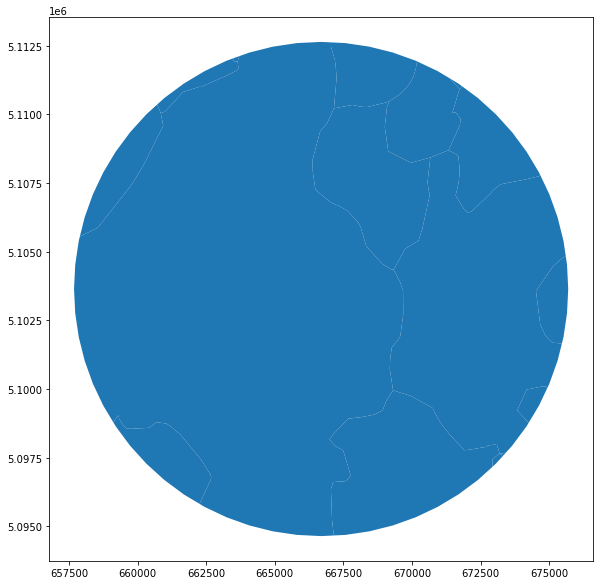

In [76]:
municipalities_inside_circle.plot(figsize=(10,10))
plt.show()

---
# Aggregation with dissolve

Spatial data are often more granular than we need. For example, we have the data of the macro-regions but we don't have a geometry with the border of Italy.

If we have a columns to operate a *groupby* we can solve it but to create the geometry we need the function *dissolve*.



In [77]:
macroregions['nation']='italy'

In [78]:
macroregions

,COD_RIP,DEN_RIP,geometry,nation
0,1,Nord-Ovest,"MULTIPOLYGON (((568226.691 4874823.573, 568219...",italy
1,2,Nord-Est,"MULTIPOLYGON (((618343.929 4893985.661, 618335...",italy
2,3,Centro,"MULTIPOLYGON (((875952.995 4524692.050, 875769...",italy
3,4,Sud,"MULTIPOLYGON (((1083358.846 4416348.741, 10833...",italy
4,5,Isole,"MULTIPOLYGON (((822886.611 3935355.889, 822871...",italy


In [79]:
italy = macroregions[['nation', 'geometry']]

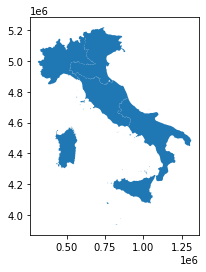

In [80]:
italy.plot()
plt.show()

In [81]:

italy = italy.to_crs(epsg=4326).dissolve(by='nation')
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [82]:
italy

,geometry
nation,
italy,"MULTIPOLYGON (((12.55959 35.50960, 12.55987 35..."


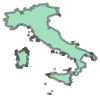

In [83]:
italy.geometry[0]

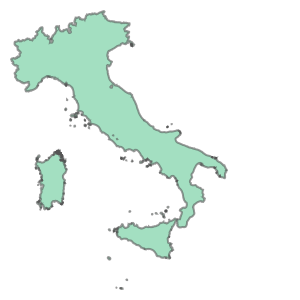

In [84]:
italy.to_crs(epsg=32632).geometry[0]

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER:</b>

dissolve can be thought of as doing three things: (a) it **dissolves** all the geometries within a given group together into a single geometric feature (using the *unary_union* method), and (b) it **aggregates** all the rows of data in a group using *groupby.aggregate()*, and (c) it **combines** those two results.
    
<ul>
<li>An overview of all methods provided by GeoPandas can be found here: <a href="http://geopandas.org/aggregation_with_dissolve.html">http://geopandas.org/aggregation_with_dissolve.html</a></li>
 </ul>

---
# Overlay

Spatial overlays allow you to compare two GeoDataFrames containing polygon or multipolygon geometries and create a new GeoDataFrame with the new geometries representing the spatial combination and merged properties. This allows you to answer questions like

    What are the demographics of the census tracts within 90km from a point?

The basic idea is demonstrated by the graphic below but keep in mind that overlays operate at the dataframe level, not on individual geometries, and the properties from both are retained

![](https://docs.qgis.org/testing/en/_images/overlay_operations.png)

source: https://geopandas.org/gallery/overlays.html


In [85]:
macroregion_gdf = macroregions[macroregions.COD_RIP==2].to_crs(epsg=32632)

In [86]:
overlay = italy.to_crs(epsg=32632).overlay(macroregion_gdf, how="difference")

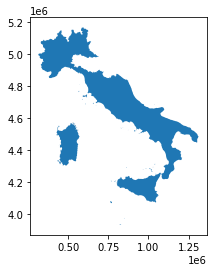

In [87]:
overlay.plot()
plt.show()

---
# Exercise
 
1 - create the geodataframe of the [gas&oil stations](https://www.mise.gov.it/images/exportCSV/anagrafica_impianti_attivi.csv) of Italy 
  - data from the italian [Ministry of Economic Development](https://www.mise.gov.it)
  - count the total of the gas&oil stations for each muncipality of Trentino

2 - identify the difference of municipalities in Trentino in the year 2019 with the year 2021
  - identify which municipalities are created from aggregation to others
  - find the biggest new municipality of Trentino and show all the italian municipalities with bordering it
  - create the macroarea of all the municipalities bordering with it
  - for each gas&oil station in the macro-area, calculate how many monumental trees have been within a 500m radius
  
3 - creates a polygon that contains all the monumental trees inside the area
  - identify all the gas&oil stations in this area which are within 2km of each other
  - save the polygon in geopackage with the attribute "description" with the name of the filling station